# import lib

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import sys
import scipy.optimize as optimize
import threading
from scipy.optimize import LinearConstraint
from datetime import datetime

npand = np.logical_and
npor = np.logical_or
npnot = np.logical_not

# load data

In [2]:

path="./" + "sidedata/"
filename = path + "Alldata2.csv"

df=pd.read_csv(filename, index_col=None)

df = df[df["FileCondi"]!="CMat"]
df['Probtype'] = np.where(df['Stimkind']==1, "CM",
                   np.where(df['Stimkind']==0, "AN",
                   np.where(df['Stimkind']==3, 'VM',"wrong")))

df['Oldnew'] = np.where(df['Old']==1, "old",
                   np.where(df['Old']==2, "new","wrong"))
df['Error'] = 1-df['Correctness']
df_giver = df
df0=df.copy()# = df.copy()
# df_giver.columns=df_giver.columns.droplevel(1)
df_org = df[df['RT']<2000]
df = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","Error","FileCondi"])[["RT"]].agg(["mean"])
# df[["Correctness","Error"]]
# df.groupby("Error")
df.index.name = 'Setsize'
df.reset_index(inplace=True)
# df["Error"]


df_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
df_crt = df_org[df_org["Error"]==0].\
groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

df_err.columns = df_err.columns.droplevel(1)
df_crt.columns = df_crt.columns.droplevel(1)

df_err = df_err.reset_index()
df_crt = df_crt.reset_index()

# Gloabal Setting

In [3]:
global vary_ss, give_c2, vary_ssan, alphabeta_ANnew
vary_ss=0
vary_ssan=0
give_c2=0
alphabeta_ANnew=1

global nameset,is_search_allcondi_besideCMat,search_MIX1
is_search_allcondi_besideCMat=0
search_MIX1 = 1
search_MIX2 = 0
nameset = df_org["FileCondi"].astype("category").cat.categories.to_numpy()
global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L, c2

# Gloabl parameters

In [4]:
alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}


# boost = 1.05
alpha["all"] = 0.19
alpha['ANnew'] = 0.1969 
# alpha['VM'] = 0.1969 
# alpha["AN"]=0.84

beta["all"] =1.2
beta['ANnew'] = 1.228
# beta['VM'] = 1.228
# beta["AN"]= 1.708

s["all"]=0.01
s["ss2"]=0.01
s["ss4"]=0.01
s["ss8"]=0.01
s["ANnew"] = 0.01
# s["AN"] = 0.01
# s["CM"] = 0.02
# s["VM"] = 0.02
c["ANpure"] = 0.3938
c["CMpure"] = 0.3938
c["VMpure"] = 0.3938
c["MIX"] = 0.3938
c["MIX2"] = 0.3938
# c["CMat"] = 0.3938
c2=0.3
Old_crit["ANpure"] = 1.9197
New_crit["ANpure"] = -2.33
Old_crit["CMpure"] = 1.9197
New_crit["CMpure"] = -2.33
Old_crit["VMpure"] = 1.9197
New_crit["VMpure"] = -2.33
Old_crit["MIX"] = 1.9197
New_crit["MIX"] = -2.33
Old_crit["MIX2"] = 1.9197
New_crit["MIX2"] = -2.33

t0["all"] = 699.98
t0["ann"] =  699.98
kao = 37

#---CM
F["ANpure_AN_oldiold_oldinew"] = 0.2

F["CMpure_CM_oldiold_oldinew"] = 0.2
L["CMpure_CM_oldiold_newinew"] = 0.2
L["CMpure_CM_oldinew_newiold"] = 0

F["VMpure_VM_oldiold_oldinew"] = 0.2
L["VMpure"] = 0.2 

F["MIX_CM_oldiold_oldinew"] = 0.2
L["MIX_CM_oldiold_newinew"] = 0.2
L["MIX_CM_oldinew_newiold"] = 0.2
F["MIX_AN_oldiold_oldinew"] = 0.2

F["MIX2_CM_oldiold_oldinew"] = 0.2
L["MIX2_CM_oldiold_newinew"] = 0.2
L["MIX2_CM_oldinew_newiold"] = 0.2
F["MIX2_AN_oldiold_oldinew"] = 0.2

# Assign_LTM_global()

In [5]:
def assign_LTM_global(Filecondi,item_condi, walk, item):
    
    global F,L,Fnow,Lnow
    if Filecondi != "VMpure":
        if item_condi == "CM":

            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":

                Fnow = F[Filecondi+"_CM_oldiold_oldinew"]
            else: Fnow = 0

            if walk+"i"+item == "oldiold" or walk+"i"+item == "newinew":

                Lnow = L[Filecondi+"_CM_oldiold_newinew"]
            elif walk+"i"+item == "oldinew" or walk+"i"+item == "newiold":

                Lnow = L[Filecondi+"_CM_oldinew_newiold"]
            else: Lnow=0

        elif item_condi == "AN":

            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":

                Fnow = F[Filecondi+"_AN_oldiold_oldinew"]
            else: Fnow=0

            Lnow = 0
            
        else: print("wrong condi 1",Filecondi,item_condi, walk+"i"+item)
            
    elif Filecondi == "VMpure":
        
        if item_condi == "VM":
            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
                Fnow = F["VMpure_VM_oldiold_oldinew"]
            else: Fnow = 0
        else: print("wrong condi 2")
            
        Lnow = L["VMpure"]
    else:
        print("wrong filecondi")
    
    return(Fnow + Lnow)

# CalcA(df) *

In [6]:
def calcA(df):

    
    dnow = df
    a = np.zeros((dnow.shape[0], 8))  #activation
    
    if vary_ss==0: snow=s["all"]
    betanow=beta["all"] 
    alphanow=alpha["all"]
    
    m = np.array([(j**(-betanow) + alphanow) for j in np.arange(1,9)])
    
    if alphabeta_ANnew==1:
        m_ANnew = np.repeat(9999.0,8)
        m_all = np.repeat(9999.0,8)
        tfcondi1 = np.array([npand.reduce((dnow["Lag"]!=j,dnow["Probtype"]=="AN",dnow["Oldnew"]=="new")) for j in range(1,9)])
        tfcondi0 = np.array([npand.reduce((dnow["Lag"]!=j,npnot(npand(dnow["Probtype"]=="AN",dnow["Oldnew"]=="new")))) for j in range(1,9)])
        tfcondi11 = np.array([npand.reduce((dnow["Lag"]==j,dnow["Probtype"]=="AN",dnow["Oldnew"]=="new")) for j in range(1,9)])
        tfcondi00 = np.array([npand.reduce((dnow["Lag"]==j,npnot(npand(dnow["Probtype"]=="AN",dnow["Oldnew"]=="new")))) for j in range(1,9)])
        
    for j in range(1,9):

        indexj = j-1
        
        
        if vary_ss==0 and alphabeta_ANnew==0:
            
            a[dnow["Lag"]==j,indexj] = m[indexj]
            a[dnow["Lag"]!=j,indexj] = m[indexj] * s["all"]
        elif vary_ss==1 and alphabeta_ANnew==0:
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==2),indexj] = m[indexj] * s["ss2"]
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==4),indexj] = m[indexj] * s["ss4"]
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==8),indexj] = m[indexj] * s["ss8"]
            a[dnow["Lag"]==j,indexj] = m[indexj]
        elif vary_ss==0 and vary_ssan==1:
            
            a[npand.reduce((\
                dnow["Lag"]!=j,npnot(npand(dnow["Probtype"]=="AN",dnow["Oldnew"]=="new")))),indexj] = m[indexj] * s["all"]
            a[npand.reduce((\
                dnow["Lag"]!=j,dnow["Probtype"]=="AN",dnow["Oldnew"]=="new")),indexj] = m[indexj] * s["ANnew"]
            a[dnow["Lag"]==j,indexj] = m[indexj]
            
        elif alphabeta_ANnew==1:
            m_all[indexj] = j**(-beta["all"]) + alpha["all"]
            m_ANnew[indexj] = j**(-beta["ANnew"]) + alpha["ANnew"]

            a[tfcondi1[indexj,:],indexj] = m_ANnew[indexj] * s["all"]
            a[tfcondi0[indexj,:],indexj] = m_all[indexj] * s["all"]
            a[tfcondi11[indexj,:],indexj] = m_ANnew[indexj]
            a[tfcondi00[indexj,:],indexj] = m_all[indexj]
        else:
            print("something wrong: CalcA")
        
        
#         print(m[indexj] * s["all"])
    for i in range(a.shape[0]): a[i,dnow['Setsize'].iloc[i]:] = 0 #a_ij suit for the correct amount of setsize
    debug = 0
    if debug==1:
        for i in range(a.shape[0]):
            print(i, "begin\n","a is",a[i].round(5),\
                  "\n m is", np.array(m).round(3),"\n Probtype is",\
                  "\n Lag is ",dnow['Lag'].iloc[i],\
                  "\n Setsize is", dnow["Setsize"].iloc[i],\
                  "\n Probtype:",\
                  dnow["Probtype"].iloc[i],\
                  "\n Oldnew: ",dnow["Oldnew"].iloc[i],\
                  "\n Ai is", a[i,:].sum().round(2),\
                  "\n snow", s["all"],\
                 "\n------------------------------------------------" )

    
    A = a.sum(axis = 1)
    
    return(A)


# calcp(df)

In [7]:
def calcp(df):
    
    dnow = df
    
    A = calcA(df)    
    p = np.repeat(3.0, A.shape[0])
    filecondis = dnow["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name

    for icondi in filecondis:
        
        #only ieterate through probs in that condition
        probs = dnow[dnow["FileCondi"]==icondi]["Probtype"].astype("category").cat.categories.to_numpy()
        for iprob in probs:

            for ion in ["old","new"]:
                    
                tf_ion = (dnow['Oldnew'] == ion)
                tf_iprob = (dnow['Probtype'] == iprob)
                tf_icondi = (dnow["FileCondi"] == icondi)
                
                tf_combi1 = np.logical_and(tf_ion, tf_iprob)
                tf_all = np.logical_and(tf_combi1,tf_icondi)

                IR_old_current = assign_LTM_global(icondi,iprob,"old",ion)
                IR_new_current = assign_LTM_global(icondi, iprob,"new",ion)

                p[tf_all] = (A[tf_all] + IR_old_current)/(A[tf_all] + IR_old_current + c[icondi] + IR_new_current)
                
#                 print(icondi,iprob,ion,IR_old_current,IR_new_current)
                
    return(np.array(p))

# name="MIX"
# df_sub_err = df_err.copy()
# df_sub_crt = df_crt.copy()
# df_sub_err=df_sub_err[df_sub_err["FileCondi"]==name]
# df_sub_crt=df_sub_crt[df_sub_crt["FileCondi"]==name]
# calcp(df_sub_crt)

# calc_theoretical_rw()

In [8]:
def calc_theoretical_RW(df, which):
    
    #which = "err" or 'crt'

    A = calcA(df)
    p = calcp(df)
    q = 1-p
    
    dnow = df
    filecondis = dnow["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    
    p_resp_old = np.zeros(p.size)
    pred_correct = np.zeros(p.size)
    pred_rt = np.zeros(p.size)

    theta1 = np.zeros(p.size)
    theta2 = np.zeros(q.size)
    theta11 = np.zeros(p.size)
    theta22 = np.zeros(q.size)
    exp_nstep = np.zeros(p.shape[0])
    
    for ifile in filecondis: 
        
        gen_tf = dnow["FileCondi"]==ifile
        AA = Old_crit[ifile]
        BB = -New_crit[ifile] # bb is a postive number
        
        if which=="crt":
            
            pq = (p[gen_tf]/q[gen_tf])
            theta1[gen_tf] = (pq**(AA+BB)+1)/(pq**(AA+BB)-1)
            theta2[gen_tf] = (pq**BB+1)/(pq**BB-1)

            tf = np.logical_and.reduce((p!=q , dnow["Oldnew"]=='old', gen_tf))
            exp_nstep[tf] = (1/(p[tf]-q[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*BB)

            tf = np.logical_and.reduce((p==q , dnow["Oldnew"]=='old', gen_tf))
            exp_nstep[tf] = (AA/3)*(2*BB+AA)
            
            theta11[gen_tf] = (pq**(-(AA+BB))+1)/(pq**(-(AA+BB))-1)
            theta22[gen_tf] = (pq**-AA+1)/(pq**-AA-1)

            tf = np.logical_and.reduce((p!=q , dnow["Oldnew"]=='new', gen_tf))
            exp_nstep[tf] = (1/(q[tf]-p[tf]))*(theta11[tf]*(AA+BB) - theta22[tf]*AA)

            tf = np.logical_and.reduce((p==q , dnow["Oldnew"]=='new', gen_tf))
            exp_nstep[tf] = (BB/3)*(2*AA+BB)
            

        #------------------- correct response
        elif which == "err":
            
            qp = (q[gen_tf]/p[gen_tf])
            qptfn =np.logical_and(p!=q,gen_tf)
            qptf =np.logical_and(p==q,gen_tf)

            p_resp_old[qptfn] = ((1-qp**BB)/(1-qp**(AA+BB)))[p[gen_tf]!=q[gen_tf]]
            p_resp_old[qptf] = BB/(AA+BB)
    #------------------
    if which=="crt":
        suprise = np.logical_and.reduce((np.logical_or(dnow["FileCondi"]=="MIX",dnow["FileCondi"]=="MIX2"),
                                         dnow["Probtype"]=="AN",dnow["Oldnew"]=="new"))
        notsuprise = np.logical_not(suprise)

        pred_rt[suprise] = t0["ann"] + kao * exp_nstep[suprise]
        pred_rt[notsuprise] = t0["all"] + kao * exp_nstep[notsuprise]

    #------------------
            
    if which == "err":
        pred_correct[dnow["Oldnew"]=='old'] = p_resp_old[dnow["Oldnew"]=="old"]
        pred_correct[dnow["Oldnew"]=="new"] = 1-p_resp_old[dnow["Oldnew"]=="new"]

    

    if which == "crt": 
#         print(pred_rt)
        return(np.array(pred_rt))
    elif which == "err":
#         print(pred_correct)
        return(np.array(pred_correct))

# calc_wssd

In [9]:
def calc_wssd(df_err,df_crt):
    w={}
        
    w["new_rt"] = 4*2
    w["old_rt"] = 1*2
    w["new_err"] = 4
    w["old_err"] = 1
    
    df_sub_err = df_err.copy()
    df_sub_crt = df_crt.copy()
    if search_MIX1==1:
        df_sub_err=df_sub_err[df_sub_err["FileCondi"]=="MIX"]
        df_sub_crt=df_sub_crt[df_sub_crt["FileCondi"]=="MIX"]
        df_sub_err.reset_index(inplace=True)
        df_sub_crt.reset_index(inplace=True)
        
    if search_MIX2==1:
        df_sub_err=df_sub_err[df_sub_err["FileCondi"]=="MIX2"]
        df_sub_crt=df_sub_crt[df_sub_crt["FileCondi"]=="MIX2"]
        df_sub_err.reset_index(inplace=True)
        df_sub_crt.reset_index(inplace=True)
        
    pred_correct = calc_theoretical_RW(df_sub_err,"err")
    pred_crt = calc_theoretical_RW(df_sub_crt,"crt")

    df_sub_crt["pred_crt"] = pred_crt/1000 #translate crt to seconds. 
    df_sub_err["pred_error"] = 1- pred_correct

    df_sub_crt["RT"]= df_sub_crt["RT"]/1000

    df_sub_crt["SSD_RT"] = ((df_sub_crt["RT"] - df_sub_crt["pred_crt"])**2).to_numpy()
    df_sub_err["SSD_err"] = ((df_sub_err["Error"] - df_sub_err["pred_error"])**2).to_numpy()

    df_sub_crt["wSSD_RT"] = [df_sub_crt.loc[i,"SSD_RT"] *\
                             w[df_sub_crt.loc[i,"Oldnew"]+"_rt"] for i in range(df_sub_crt.shape[0])]

    df_sub_err["wSSD_err"] = [df_sub_err.loc[i,"SSD_err"] *\
                             w[df_sub_err.loc[i,"Oldnew"] + "_err"] for i in range(df_sub_err.shape[0])]
    
    
    adj_oldnew=0
    if adj_oldnew==1:
        print("\nERR","old",df_sub_err[df_sub_err["Oldnew"]=="old"]["wSSD_err"].sum(),\
             "new",df_sub_err[df_sub_err["Oldnew"]=="new"]["wSSD_err"].sum(),
             "\nRT","old",df_sub_crt[df_sub_crt["Oldnew"]=="old"]["wSSD_RT"].sum(),\
             "new",df_sub_crt[df_sub_crt["Oldnew"]=="new"]["wSSD_RT"].sum(),)
    #     print(df_sub_err[df_sub_err["Oldnew"]=="old"].sum() + df[df_sub_crt["Oldnew"]=="new"].sum())

    WSSD = df_sub_err["wSSD_err"].sum() + df_sub_crt["wSSD_RT"].sum()
    
#     print(df_sub_crt)
    return(WSSD)

calc_wssd(df_err,df_crt)

2.660396672013317

# random_start() *

In [10]:
def random_start():
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L
  
    alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}

    alpha["all"] = np.random.uniform(0.1,3)
    alpha["ANnew"] = np.random.uniform(0.1,3)
    beta["all"] = np.random.uniform(0.01,4)
    beta["ANnew"] = np.random.uniform(0.01,4)
    s["all"]= np.random.uniform(0.01,0.999)
    s["ss2"]= np.random.uniform(0.01,0.999)
    s["ss4"]= np.random.uniform(0.01,0.999)
    s["ss8"]= np.random.uniform(0.01,0.999)
    s["ANnew"]= np.random.uniform(0.01,0.999)
    c["ANpure"] = np.random.uniform(0.01,0.99)
    c["CMpure"] = np.random.uniform(0.01,0.99)
    c["VMpure"] = np.random.uniform(0.01,0.99)
    c["MIX"] = np.random.uniform(0.01,0.99)
    c["MIX2"] = np.random.uniform(0.01,0.99)

    Old_crit["ANpure"] = np.random.uniform(1,10)
    New_crit["ANpure"] = np.random.uniform(-10,1)
    Old_crit["CMpure"] = np.random.uniform(1,10)
    New_crit["CMpure"] = np.random.uniform(-10,1)
    Old_crit["VMpure"] = np.random.uniform(1,10)
    New_crit["VMpure"] = np.random.uniform(-10,1)
    Old_crit["MIX"] = np.random.uniform(1,10)
    New_crit["MIX"] = np.random.uniform(-10,1)
    Old_crit["MIX2"] = np.random.uniform(1,10)
    New_crit["MIX2"] = np.random.uniform(1,10)

    t0["all"] =  np.random.uniform(1,900)
    t0["ann"] =  np.random.uniform(1,900)
    
    kao = np.random.uniform(1,100)

    #---CM
    F["ANpure_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)

    F["CMpure_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["CMpure_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["CMpure_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    
    F["VMpure_VM_oldiold_oldinew"] = np.random.uniform(0.0001,1) 
    L["VMpure"] = np.random.uniform(0.0001,1) 

    F["MIX_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["MIX_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["MIX_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    F["MIX_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)

    F["MIX2_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["MIX2_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["MIX2_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    F["MIX2_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    
    if vary_ss==0 and  is_search_allcondi_besideCMat==1 and False:
        
        print("vary_ss==0 and  is_search_allcondi_besideCMat==1")
        
        
        param_dic=np.array((\
            alpha["all"],beta["all"],s["all"],
            c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
            Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
            Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
            t0["all"] ,t0["ann"] ,kao,
            F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,
                            L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
            F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
            F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
                            L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
            F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
                            L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]))
    elif search_MIX1==1 and vary_ss==0 and alphabeta_ANnew==0:
        
        print("search_MIX1==1 and vary_ss==0")
        
        
        param_dic=np.array((alpha["all"], beta["all"], s["all"],
                             c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
                             F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
                             F["MIX_AN_oldiold_oldinew"]))
            
    elif search_MIX1==1 and vary_ss==1 and alphabeta_ANnew==0:
        
        print("search_MIX1==1 and vary_ss==1")
        
        
        param_dic=np.array((\
            alpha["all"],beta["all"],s["ss2"],s["ss4"],s["ss8"],
                             c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
                             F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
                             F["MIX_AN_oldiold_oldinew"]))
    elif search_MIX1==1 and vary_ss==0 and vary_ssan==1:
        
        print("search_MIX1==1 and vary_ss==0 and vary_ssan==1")
        
        
        param_dic=np.array((alpha["all"], beta["all"], s["all"],s["ANnew"],
                             c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
                             F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
                             F["MIX_AN_oldiold_oldinew"]))
    elif search_MIX2==1 and vary_ss==0 and vary_ssan==1:
        
        print("search_MIX2==1 and vary_ss==0 and vary_ssan==1")
        
        
        param_dic=np.array((alpha["all"], beta["all"], s["all"],s["ANnew"],
                             c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
                             F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
                             L["MIX2_CM_oldinew_newiold"],F["MIX2_AN_oldiold_oldinew"]))
    elif search_MIX2==1 and vary_ss==1 and vary_ssan==0:
        
        printnt("search_MIX2==1 and vary_ss==1 and vary_ssan==0")
        
        
        param_dic=np.array((alpha["all"], beta["all"],s["ss2"],s["ss4"],s["ss8"],
         c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
         F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"],
         F["MIX2_AN_oldiold_oldinew"]))
        
    elif alphabeta_ANnew==1 and search_MIX1==1:
        
        print("alphabeta_ANnew==1 and search_MIX1==1")
        
        
        param_dic=np.array((alpha["all"],alpha["ANnew"], beta["all"],beta["ANnew"],s["all"],
        c["MIX"] ,Old_crit["MIX"] ,New_crit["MIX"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]))
        
    elif alphabeta_ANnew==1 and search_MIX2==1:
        
        print("alphabeta_ANnew==1 and search_MIX2==1")
        
        
        param_dic=np.array((alpha["all"],alpha["ANnew"], beta["all"],beta["ANnew"],s["all"],
        c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
                             F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
                             L["MIX2_CM_oldinew_newiold"],F["MIX2_AN_oldiold_oldinew"]))
                           
    else: 
        print("something wrong random_start")
        
        
        
    return(param_dic)

params_dic=random_start()

alphabeta_ANnew==1 and search_MIX1==1


In [11]:
search_MIX2

0

# optim_wsse(params_dic)*

In [12]:
def optim_wsse(params_dic):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L

    alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}
    
    # print(params)  # <-- you'll see that params is a NumPy array
    if vary_ss==0 and is_search_allcondi_besideCMat==1:
        print("vary_ss==0 and  is_search_allcondi_besideCMat==1")
        
        [alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,
         Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,
         F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], 
         F["MIX2_AN_oldiold_oldinew"]] = params_dic
        
    elif search_MIX1==1 and vary_ss==0 and alphabeta_ANnew==0:

        print("search_MIX1==1 and vary_ss==0, alphabeta_ANnew==0")
    
        [alpha["all"],beta["all"],s["all"],
        c["MIX"] ,
        Old_crit["MIX"] ,New_crit["MIX"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]\
        = params_dic
    elif search_MIX1==1 and vary_ss==1 and alphabeta_ANnew==0:

        print("search_MIX1==1 and vary_ss==1, alphabeta_ANnew==0")
        [ alpha["all"],beta["all"],s["ss2"],s["ss4"],s["ss8"],
                             c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
                             F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
                             F["MIX_AN_oldiold_oldinew"]] = params_dic
    elif search_MIX1==1 and vary_ss==0 and vary_ssan==1:
        
        print("search_MIX1==1 and vary_ss==0 and vary_ssan==1")
        [alpha["all"],beta["all"],s["all"],s["ANnew"],
        c["MIX"] ,
        Old_crit["MIX"] ,New_crit["MIX"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]\
        = params_dic
    elif search_MIX2==1 and vary_ss==0 and vary_ssan==1:
        
        print("search_MIX2==1 and vary_ss==0 and vary_ssan==1")
        [alpha["all"], beta["all"], s["all"],s["ANnew"],
         c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
         F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
         L["MIX2_CM_oldinew_newiold"],F["MIX2_AN_oldiold_oldinew"]]\
        = params_dic
    elif search_MIX2==1 and vary_ss==1 and vary_ssan==0:

        print("search_MIX2==1 and vary_ss==1 and vary_ssan==0")
        [alpha["all"], beta["all"],s["ss2"],s["ss4"],s["ss8"],
         c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
         F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"],
         F["MIX2_AN_oldiold_oldinew"]] = params_dic
        
    elif alphabeta_ANnew==1 and search_MIX1==1:
        
        print("alphabeta_ANnew==1 and search_MIX1==1")
        [alpha["all"],alpha["ANnew"], beta["all"],beta["ANnew"],s["all"],
        c["MIX"] ,Old_crit["MIX"] ,New_crit["MIX"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]] = params_dic

    elif alphabeta_ANnew==1 and search_MIX2==1:
        
        print("alphabeta_ANnew==1 and search_MIX2==1")
        [alpha["all"],alpha["ANnew"], beta["all"],beta["ANnew"],s["all"],
        c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
                             F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
                             L["MIX2_CM_oldinew_newiold"],F["MIX2_AN_oldiold_oldinew"]]=params_dic
        
        
    else:
        print("something wrong Optim_wsse")
        
    return calc_wssd(df_err,df_crt)

optim_wsse(random_start())

alphabeta_ANnew==1 and search_MIX1==1
alphabeta_ANnew==1 and search_MIX1==1


66.6683757200302

# finalRW

In [13]:
def finalRW(df_what,kind):

    if kind == "err":
        df_what["Pred_error"] = 1-calc_theoretical_RW(df_what,kind)
    elif kind == "crt":
        df_what["Pred_cRT"]=calc_theoretical_RW(df_what,kind)
    else: print("error input of name kind")
    
    return(df_what)

# all_plot

In [14]:
def all_plot(df_all,plotwhaty,ylim):
    df_all_err = df_all.copy()
    df_all_agg = df_all_err.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
    df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
    df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1])

#     df_all_aggnew.index.name = 'Setsize'
    df_all_aggnew.reset_index(inplace=True)
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    plt.figure()
#     plt.title(plotwhaty)
    for iname in names:
        
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1
    
    plt.show()
    plt.close()

# grant plot*

In [15]:
def grant_plot(fitsel, which, lowl, highl, is_grant=1, which_pic=1, true=0):
    
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L

    alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}
    
    print("\nFrom Grant Plot:\n")
    
    if is_grant==0: iter_range=np.array([which_pic])
    else: iter_range = np.array(range(fitsel.shape[0]-1))
    for i in iter_range:

        if vary_ss==0 and is_search_allcondi_besideCMat==1:
            
            print("vary_ss==0 and is_search_allcondi_besideCMat==1")
            [alpha["all"],beta["all"],s["all"],
            c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
            Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
            Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
            t0["all"] ,t0["ann"] ,kao,
            F["ANpure_AN_oldiold_oldinew"] ,
             F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
            F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
            F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], 
             L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
            F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
             L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
            fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()

            df_crt_pred = finalRW(df_crt,"crt")
            df_err_pred = finalRW(df_err,"err")

        elif search_MIX1==1 and vary_ss==0 and vary_ssan==0 and alphabeta_ANnew==0:
            
            print("search_MIX1==1 and vary_ss==0 and vary_ssan==0 and alphabeta_ANnew==0")
            [alpha["all"], beta["all"], s["all"],
             c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
             F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
             F["MIX_AN_oldiold_oldinew"]]=\
            fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()     

            df_crt_sub=df_crt.copy()
            df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX"]
            df_err_sub=df_err.copy()
            df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX"]

            df_crt_pred = finalRW(df_crt_sub,"crt")
            df_err_pred = finalRW(df_err_sub,"err")
#         elif search_MIX2==1 and vary_ss==0 and vary_ssan==0:

#             [alpha["all"], beta["all"], s["all"],
#              c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
#              F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"],
#              F["MIX2_AN_oldiold_oldinew"]]=\
#             fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()

#             df_crt_sub=df_crt.copy()
#             df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX2"]
#             df_err_sub=df_err.copy()
#             df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX2"]

#             df_crt_pred = finalRW(df_crt_sub,"crt")
#             df_err_pred = finalRW(df_err_sub,"err")
        elif search_MIX1==1 and vary_ss==1:
            
            print("search_MIX1==1 and vary_ss==1")
            [alpha["all"], beta["all"],s["ss2"],s["ss4"],s["ss8"],
             c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
             F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
             F["MIX_AN_oldiold_oldinew"]]=\
            fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()

            df_crt_sub=df_crt.copy()
            df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX"]
            df_err_sub=df_err.copy()
            df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX"]

            df_crt_pred = finalRW(df_crt_sub,"crt")
            df_err_pred = finalRW(df_err_sub,"err")
        elif search_MIX1==1 and vary_ss==0 and vary_ssan==1:
            
            print("search_MIX1==1 and vary_ss==0 and vary_ssan==1")
            [alpha["all"], beta["all"],s["all"],s["ANnew"],
             c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
             F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
             F["MIX_AN_oldiold_oldinew"]]=\
            fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()

            df_crt_sub=df_crt.copy()
            df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX"]
            df_err_sub=df_err.copy()
            df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX"]

            df_crt_pred = finalRW(df_crt_sub,"crt")
            df_err_pred = finalRW(df_err_sub,"err")
        
        elif search_MIX2==1 and vary_ss==0 and vary_ssan==1:
            
            print("search_MIX2==1 and vary_ss==0 and vary_ssan==1")
            [alpha["all"], beta["all"],s["all"],s["ANnew"],
             c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
             F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"],
             F["MIX2_AN_oldiold_oldinew"]]=\
            fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()

            df_crt_sub=df_crt.copy()
            df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX2"]
            df_err_sub=df_err.copy()
            df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX2"]

            df_crt_pred = finalRW(df_crt_sub,"crt")
            df_err_pred = finalRW(df_err_sub,"err")
        elif search_MIX2==1 and vary_ss==1 and vary_ssan==0:
            
            print("search_MIX2==1 and vary_ss==1 and vary_ssan==0")
            [alpha["all"], beta["all"],s["ss2"],s["ss4"],s["ss8"],
             c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
             F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"],
             F["MIX2_AN_oldiold_oldinew"]]=\
            fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()

            df_crt_sub=df_crt.copy()
            df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX2"]
            df_err_sub=df_err.copy()
            df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX2"]

            df_crt_pred = finalRW(df_crt_sub,"crt")
            df_err_pred = finalRW(df_err_sub,"err")
            
        elif alphabeta_ANnew==1 and search_MIX1==1:
            
            print("alphabeta_ANnew==1 and search_MIX1==1")
            [alpha["all"],alpha["ANnew"], beta["all"],beta["ANnew"],s["all"],
            c["MIX"] ,Old_crit["MIX"] ,New_crit["MIX"] ,
            t0["all"] ,t0["ann"] ,kao,
            F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
             L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]] = fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()
            
            df_crt_sub=df_crt.copy()
            df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX"]
            df_err_sub=df_err.copy()
            df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX"]

            df_crt_pred = finalRW(df_crt_sub,"crt")
            df_err_pred = finalRW(df_err_sub,"err")
        
        elif alphabeta_ANnew==1 and search_MIX2==1:
            
            print("alphabeta_ANnew==1 and search_MIX2==1")
            [alpha["all"],alpha["ANnew"], beta["all"],beta["ANnew"],s["all"],
            c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
                                 F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
                                 L["MIX2_CM_oldinew_newiold"],F["MIX2_AN_oldiold_oldinew"]]=\
            fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()
            
            df_crt_sub=df_crt.copy()
            df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX2"]
            df_err_sub=df_err.copy()
            df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX2"]

            df_crt_pred = finalRW(df_crt_sub,"crt")
            df_err_pred = finalRW(df_err_sub,"err")
            
        else:
            print("Something is wrong here *grant_plot")


            
        print("**",i,fitsel["wssd"][i],"**","\n Prediction\n")
#         print("**",i,calc_wssd(df_err_sub,df_crt_sub),"**")
        
        
        if which=="err":

            if true!=1: all_plot(df_err_pred,"Pred_error",(lowl,highl))
            if i==fitsel.shape[0]-2 or npand(true==1,iter_range.size==1):
                print("true")
                if search_MIX1==1: all_plot(df_err_pred[df_err_pred["FileCondi"]=="MIX"],"Error",(lowl,highl))
                if search_MIX2==1: all_plot(df_err_pred[df_err_pred["FileCondi"]=="MIX2"],"Error",(lowl,highl)) 

        elif which=="crt":

            if true!=1: all_plot(df_crt_pred,"Pred_cRT",(lowl,highl))
            if i==fitsel.shape[0]-2 or npand(true==1,iter_range.size==1):
                print("true")
                if search_MIX1==1: all_plot(df_crt[df_crt["FileCondi"]=="MIX"],"RT",(lowl,highl))
                if search_MIX2==1: all_plot(df_crt_sub[df_crt_pred["FileCondi"]=="MIX2"],"RT",(lowl,highl))

        
        


# **** PLOT

## plot from julia

** 0 0.3417220851617615 **


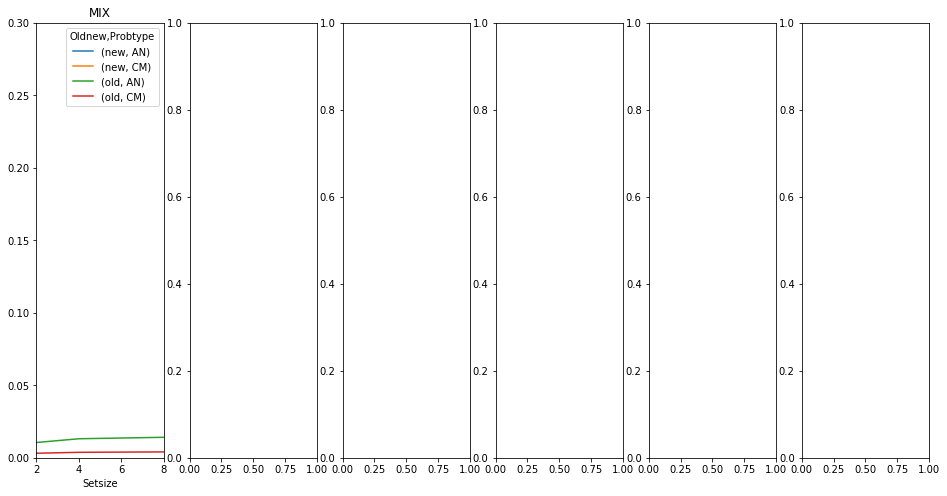

<Figure size 432x288 with 0 Axes>

** 1 5.567164473705285 **


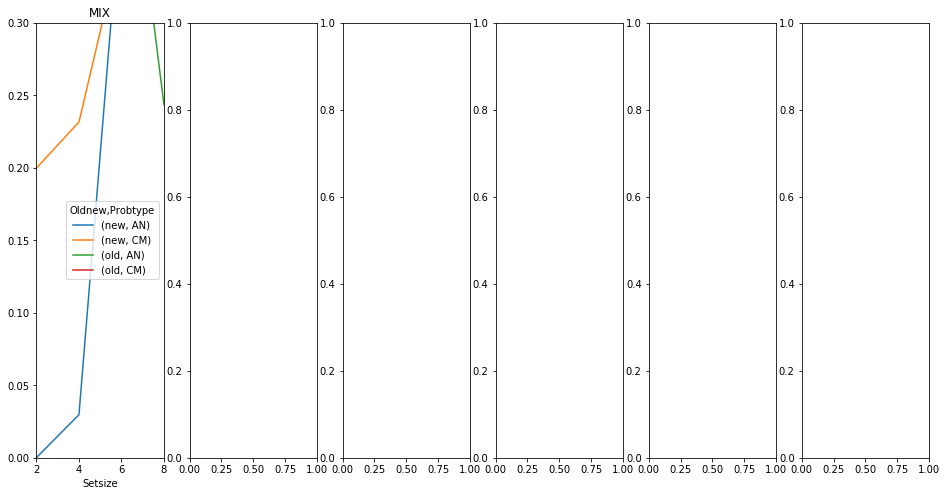

<Figure size 432x288 with 0 Axes>

** 2 0.4148774175916613 **


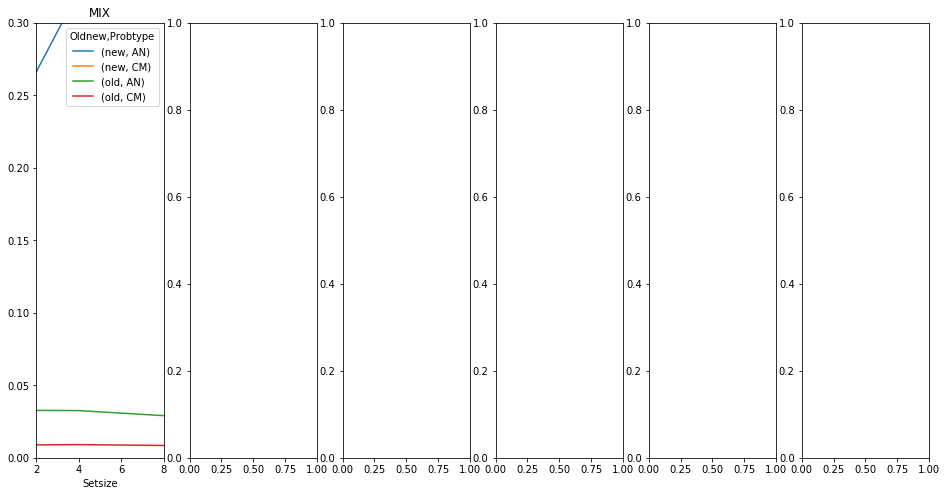

<Figure size 432x288 with 0 Axes>

** 3 5.235984581184673 **


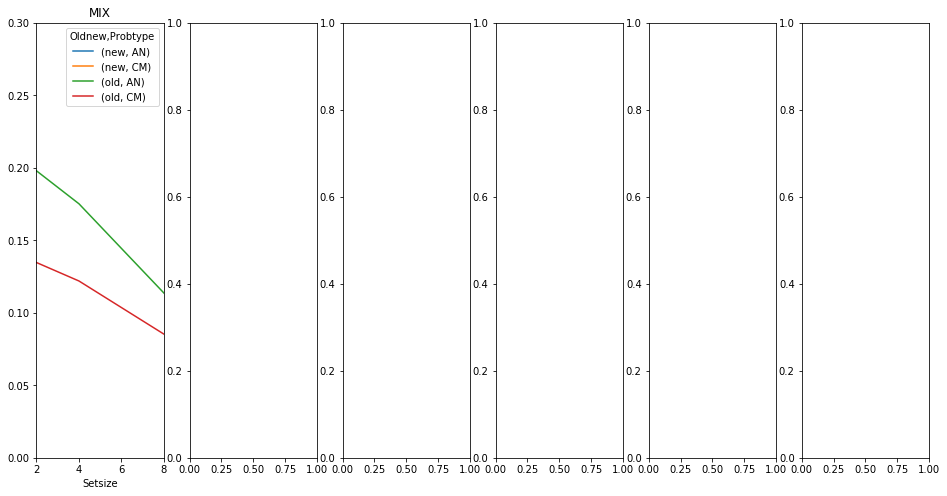

<Figure size 432x288 with 0 Axes>

** 4 0.3159135392740826 **


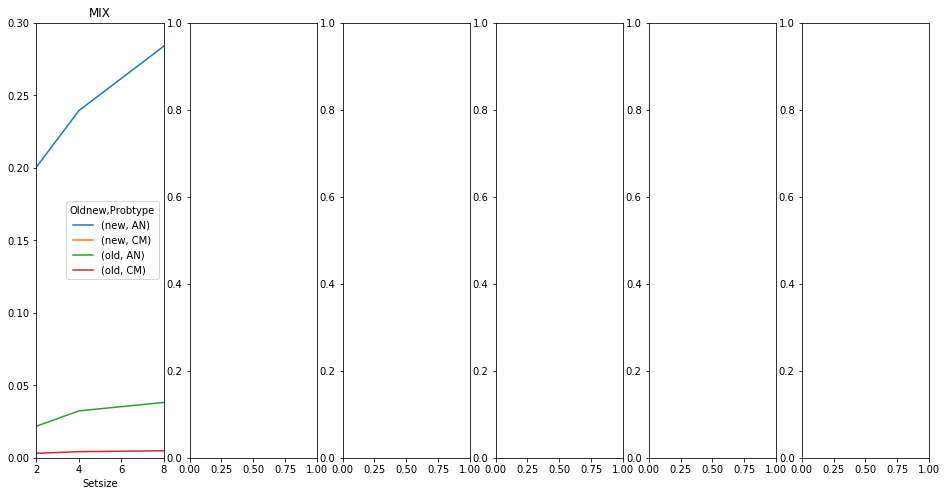

<Figure size 432x288 with 0 Axes>

** 5 0.22110585896607904 **


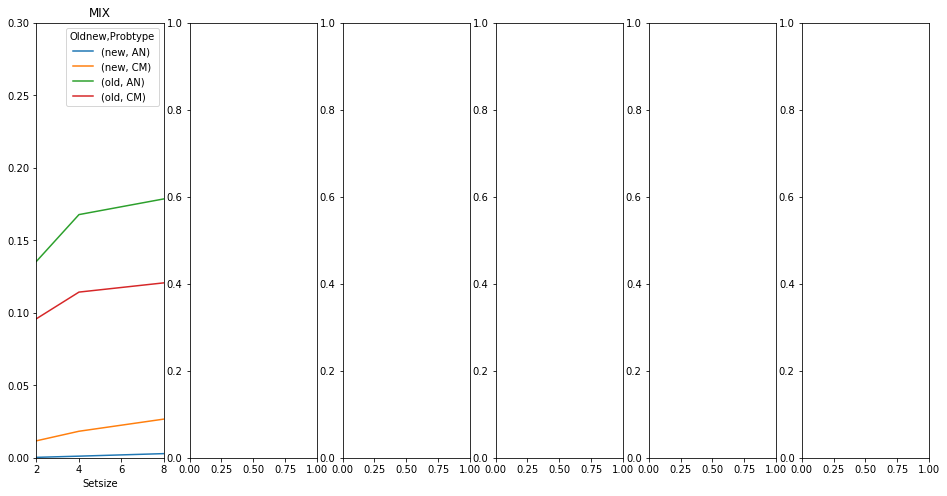

<Figure size 432x288 with 0 Axes>

** 6 0.4379023936520528 **


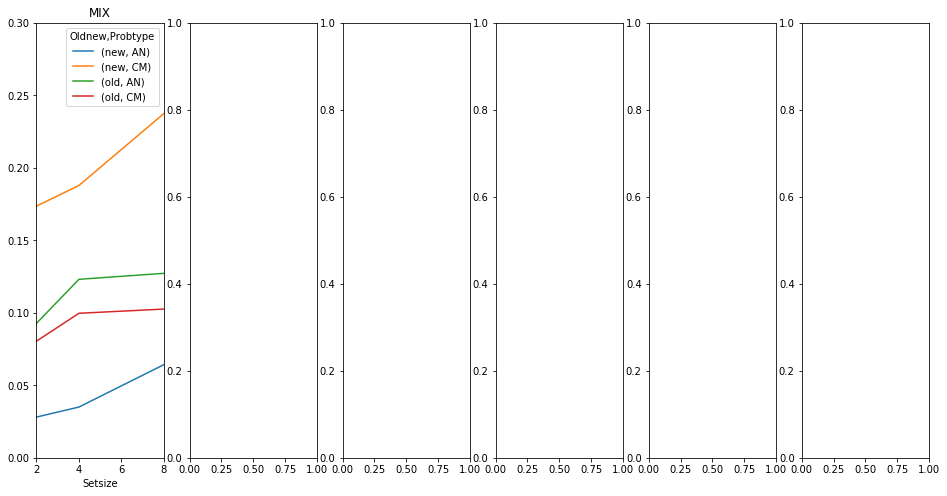

<Figure size 432x288 with 0 Axes>

** 7 0.3351616487169212 **


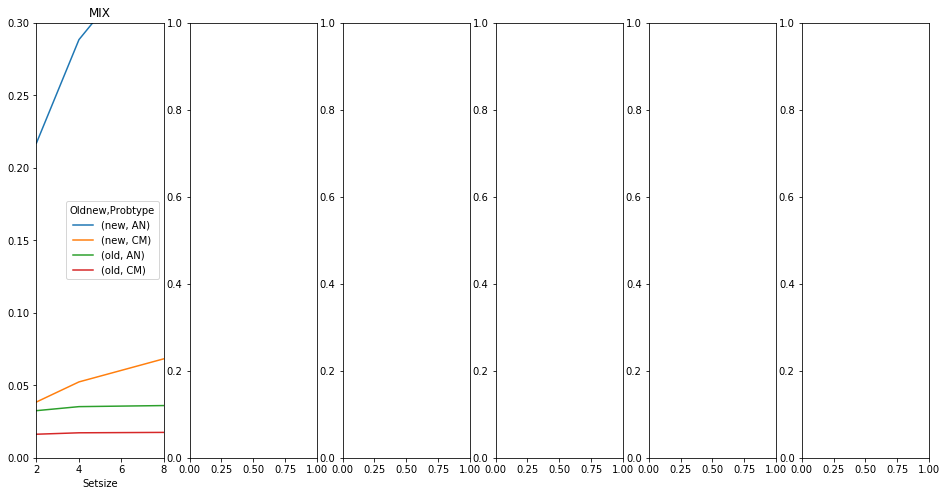

<Figure size 432x288 with 0 Axes>

** 8 0.2521266602522841 **


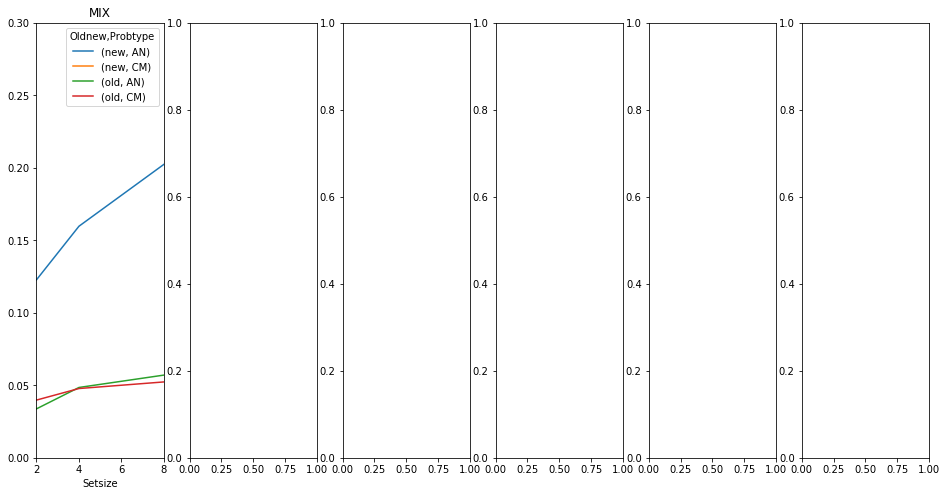

<Figure size 432x288 with 0 Axes>

true


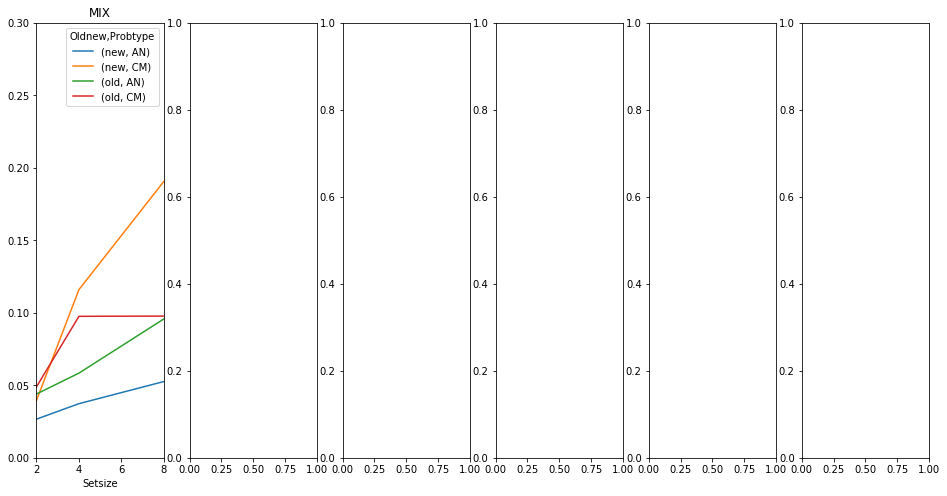

<Figure size 432x288 with 0 Axes>

In [174]:
global vary_ss, give_c2, vary_ssan
vary_ss=1
vary_ssan=0
give_c2=0

global nameset,is_search_allcondi_besideCMat,search_MIX1
is_search_allcondi_besideCMat=0
search_MIX1 = 1
search_MIX2 = 0
nameset = df_org["FileCondi"].astype("category").cat.categories.to_numpy()


fitsel = pd.read_csv("2019-12-04T00:34:37.073_julia_MIX1_ss-revise-changeopt.csv")
fitsel=fitsel.join(pd.DataFrame(np.zeros(fitsel.shape[1])))
fitsel
# grant_plot(fitsel,"crt",700,1000)
grant_plot(fitsel,"err",0,0.3)

In [60]:
fitsel.shape

(5, 17)

## plot from python

In [160]:
fitsel = pd.read_csv("12_02_12_33_puresingle_test_MIX2_vary_ss.csv").iloc[:,1:]
[alpha["all"], beta["all"],s["ss2"],s["ss4"],s["ss8"],
             c["MIX2"], Old_crit["MIX2"], New_crit["MIX2"], t0["all"],t0["ann"], kao,
             F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"],
             F["MIX2_AN_oldiold_oldinew"]]=\
            fitsel.iloc[4,:fitsel.shape[1]-2].astype(float).to_list()

In [162]:
vary_ss=1
vary_ssan=0
give_c2=0

global nameset,is_search_allcondi_besideCMat,search_MIX1
is_search_allcondi_besideCMat=0
search_MIX1 = 0
search_MIX2 = 1


name="MIX2"
df_sub_err = df_err.copy()
df_sub_crt = df_crt.copy()
df_sub_err=df_sub_err[df_sub_err["FileCondi"]==name]
df_sub_crt=df_sub_crt[df_sub_crt["FileCondi"]==name]
print("\n-----",calc_theoretical_RW(df_sub_crt,"crt"),df_sub_crt["RT"])
# print("\n-----",calcA(df_sub_crt))


----- [870.19223099 890.89858791 888.59984014 914.59538661 961.01156487
 982.80175074 796.58989351 903.45306302 800.74709369 895.76442874
 796.21508163 898.58431139 963.45500298 991.62027121 800.36210807
 891.93344684 941.00978192 961.91748483 795.03269007 884.97256904
 938.98511627 963.10900325 974.61318122 980.73911315 984.31807087
 986.56519834 799.14474418 881.03398334 922.87806271 940.75450608
 949.24824902 953.78767056 956.45015203 958.12702553] 2       896.760000
5       866.102908
9       887.398649
12      909.243956
16      937.880392
19     1012.118812
23      798.801653
26      781.254310
29      802.816667
32      930.840376
37      767.435185
40      883.847458
43      896.247191
46     1006.974138
49      783.481481
52      901.890909
55      970.726415
58      984.019802
65      914.150000
68      907.671875
71     1001.629032
74     1006.745455
77      983.275000
80      981.147541
83     1006.672131
86      936.770492
89      775.457627
92      842.078125
95      963

In [15]:
global vary_ss, give_c2, vary_ssan, alphabeta_ANnew
vary_ss=0
vary_ssan=0
give_c2=0
alphabeta_ANnew=1

global nameset,is_search_allcondi_besideCMat,search_MIX1
is_search_allcondi_besideCMat=0
search_MIX1 = 1
search_MIX2 = 0

# nm="12_02_12_33_puresingle_test_MIX2_vary_ss.csv"
nm = "2019-12-04T05:16:46_single_test_MIX1_alphabeta-ANnew.csv"
fitsel = pd.read_csv(nm).iloc[:,1:]
# fitsel.shape
which_pic=6

grant_plot(fitsel,"crt",780,1040,is_grant=0,which_pic=which_pic)
grant_plot(fitsel,"err",0,0.3,is_grant=0,which_pic=which_pic)

fitsel["t0"][which_pic]=638

grant_plot(fitsel,"crt",780,1040,is_grant=0,which_pic=which_pic)
grant_plot(fitsel,"err",0,0.3,is_grant=0,which_pic=which_pic)


# grant_plot(fitsel,"crt",780,1040,true=1)
# grant_plot(fitsel,"err",0,0.3,true=1)

FileNotFoundError: [Errno 2] File b'2019-12-04T05:16:46_single_test_MIX1_alphabeta-ANnew.csv' does not exist: b'2019-12-04T05:16:46_single_test_MIX1_alphabeta-ANnew.csv'

In [171]:
fitsel

,alpha,beta,s_ss2,s_ss4,s_ss8,c,old_crt,new_crt,t0,t0ann,kappa,F_cmoonn,L_cmoonn,Lcmonno,an_oool,wssd,w
0,0.243584349170678,2.29576438126046,0.01,0.013194592807346,0.021462827426077,0.200461958126083,3.82795730370735,-3.6028704054025,638.730233835774,742.716726397961,29.8942157715742,0.056204960874706,0.043945120786779,0.033945120789737,1.29965679563005E-11,3.201999,new_rt:50
1,0.244027927068505,2.2938744068807,0.010000000000111,0.013201351379523,0.021466016963274,0.200821380871323,3.82825713947544,-3.60258779946881,638.571285947617,742.676947828319,29.9081794539222,0.056321985043696,0.044019365958745,0.034019365958948,1.91712562233586E-13,3.222514,old_rt:10
2,0.257812165732617,2.24736095108911,0.01,0.013305596734106,0.021634634363348,0.211571360601621,3.92320731328931,-3.63307345009048,635.582935810951,745.315560393506,29.2589959257338,0.060926024106956,0.04836335474817,0.038363354748172,0,3.759242,new_err:5
3,0.151105232569456,2.65791490956432,0.010000000031572,0.0132211556471,0.022399906575411,0.167987545164338,3.80302831767269,-4.09485800231419,689.342266015696,701.652332448786,22.2998105676819,0.057252919795242,0.013601068076938,0.003601068106534,0.036551289402449,0.836318,old_err:1
4,0.241966169988135,2.30191523706527,0.010000000000381,0.013179119717044,0.02143127519917,0.199082109593695,3.81700827093649,-3.59791017720972,638.976779642932,742.314322964718,29.9951899380152,0.055647341104556,0.043399227006582,0.033399227002703,0,3.149768,--------------
5,0.2451262106944,2.28976432609157,0.01,0.013216438232755,0.021491653576453,0.201817415871007,3.83288710223022,-3.60702066014934,638.449938511143,742.844620096586,29.8504229523005,0.056634374199839,0.044348636700855,0.03434863670085,1.63891775567511E-15,3.256967,--------------
6,0.150143073831689,2.66512104276131,0.01,0.013204652690356,0.022360100444448,0.166727773528468,3.81168417046603,-4.08876611291778,689.414121002821,701.768171140926,22.275744103188,0.056964238182511,0.01359208066483,0.003592080664735,0.036357785643444,0.840368,--------------
7,0.01 ~ 1.0,0.01 ~ 3.0,0.01 ~ 1.0,0.01 ~ 1.0,0.01 ~ 1.0,0.01 ~ 2.0,1.0 ~ 8.0,-8.0 ~ -1.0,100.0 ~ 800.0,100.0 ~ 800.0,5.0 ~ 100.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.000000,--------------


In [ ]:
[alpha["all"],alpha["ANnew"], beta["all"],beta["ANnew"],s["all"],
        c["MIX"] ,Old_crit["MIX"] ,New_crit["MIX"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]] = params_dics
    else:

In [50]:
global vary_ss, give_c2, vary_ssan, alphabeta_ANnew
vary_ss=0
vary_ssan=0
give_c2=0
alphabeta_ANnew=1

global nameset,is_search_allcondi_besideCMat,search_MIX1
is_search_allcondi_besideCMat=0
search_MIX1 = 0
search_MIX2 = 1

# nm="12_02_12_33_puresingle_test_MIX2_vary_ss.csv"
nm = "2019-12-04T09:14:14_single_test_MIX2_alphabeta-ANnew.csv"
fitsel = pd.read_csv(nm).iloc[:,1:]

[alpha["all"],alpha["ANnew"], beta["all"],beta["ANnew"],s["all"],
        c["MIX"] ,Old_crit["MIX"] ,New_crit["MIX"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]=\
            fitsel.iloc[1,:fitsel.shape[1]-2].astype(float).to_list()

name="MIX"
df_sub_err = df_err.copy()
df_sub_crt = df_crt.copy()
df_sub_err=df_sub_err[df_sub_err["FileCondi"]==name]
df_sub_crt=df_sub_crt[df_sub_crt["FileCondi"]==name]
print("\n-----",calc_theoretical_RW(df_sub_crt,"crt"))
# print("\n-----",calcA(df_sub_crt))
# print("\n",calcp(df_sub_crt))


# grant_plot(fitsel,"crt",0,2000)
# grant_plot(fitsel,"err",0,1)


----- [881.07026658 892.2195402  899.46870713 927.73589633 927.70765512
 982.81897031 805.59262356 915.62670038 805.30469449 908.40710714
 804.60122109 905.0701396  960.50423471 981.43051373 804.3388437
 898.73273063 949.74935992 969.53879792 803.03541248 889.76819294
 936.18477433 954.70290593 962.95937899 967.17130452 969.55731384
 971.01970091 802.81158977 884.67806053 927.25866473 944.35050571
 952.04310886 955.99257032 958.23891352 959.61924705]


# 888888888888888888


From Grant Plot:

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 0 3.20199898480006 ** 
 Prediction



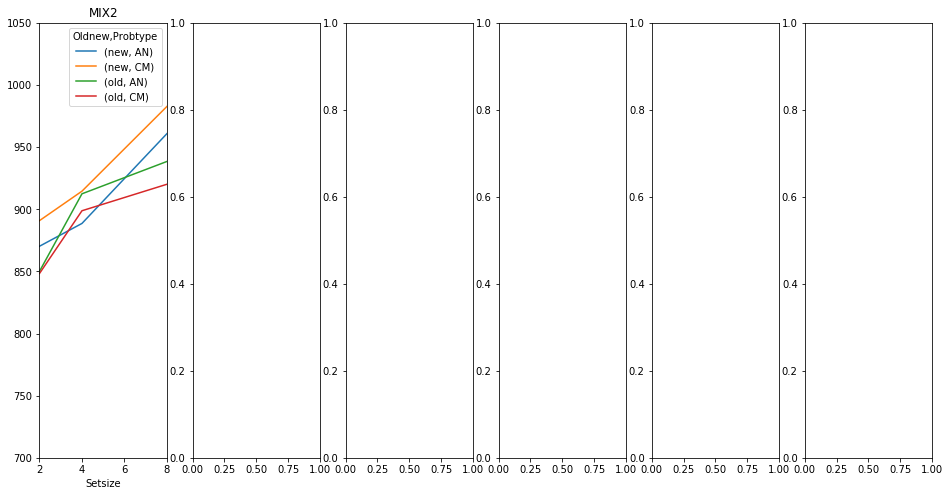

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 1 3.2225143495093596 ** 
 Prediction



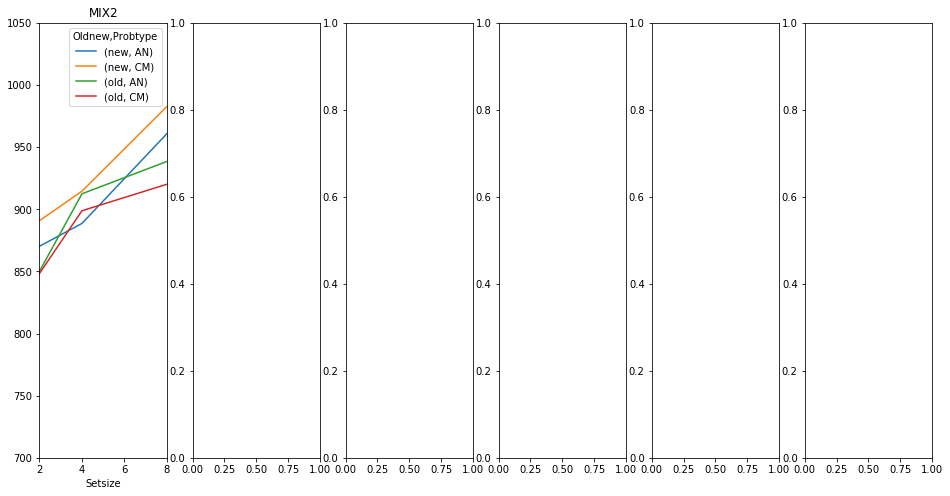

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 2 3.7592420380386002 ** 
 Prediction



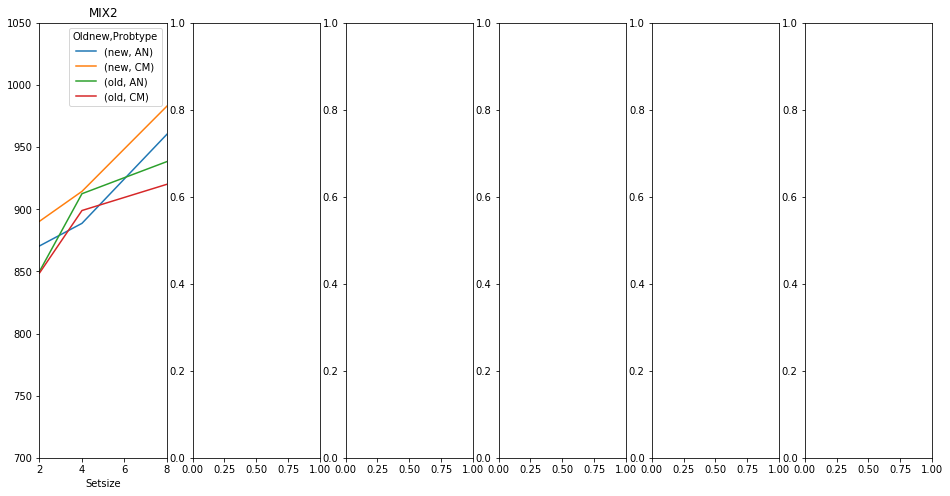

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 3 0.8363179232423911 ** 
 Prediction



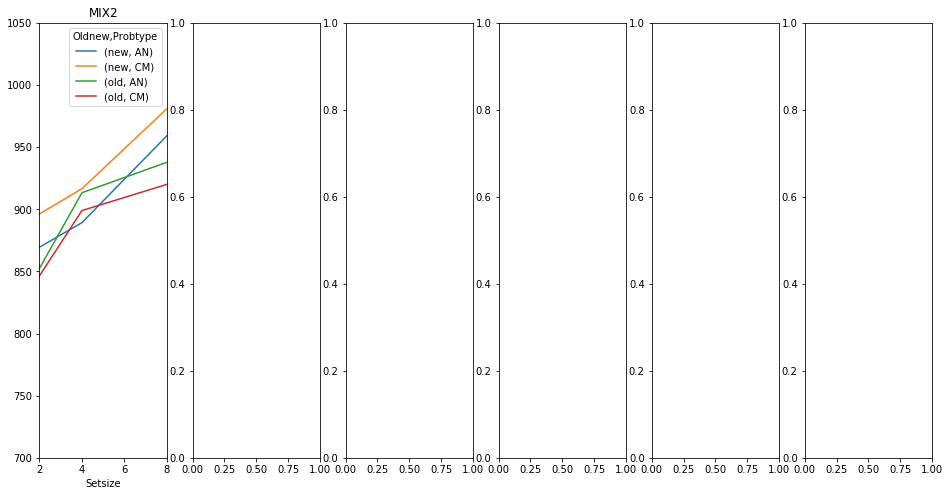

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 4 3.1497676083004302 ** 
 Prediction



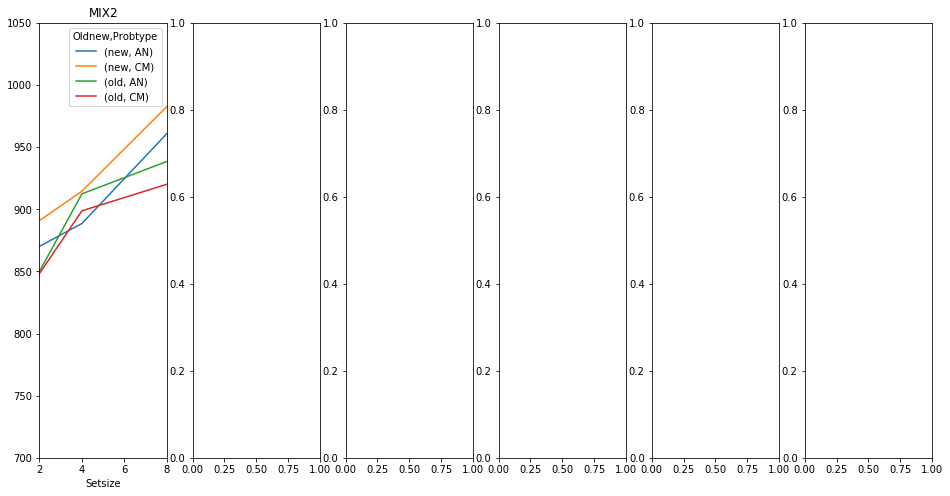

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 5 3.25696747983922 ** 
 Prediction



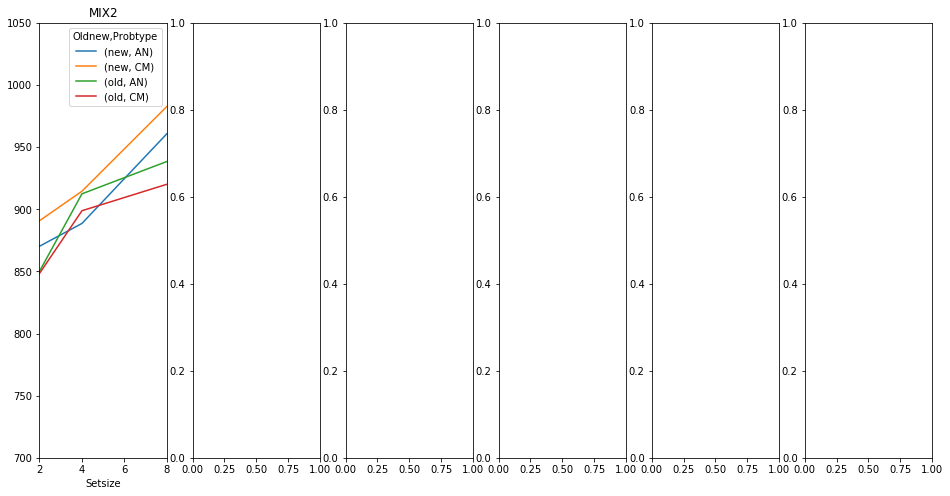

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 6 0.840367886288404 ** 
 Prediction



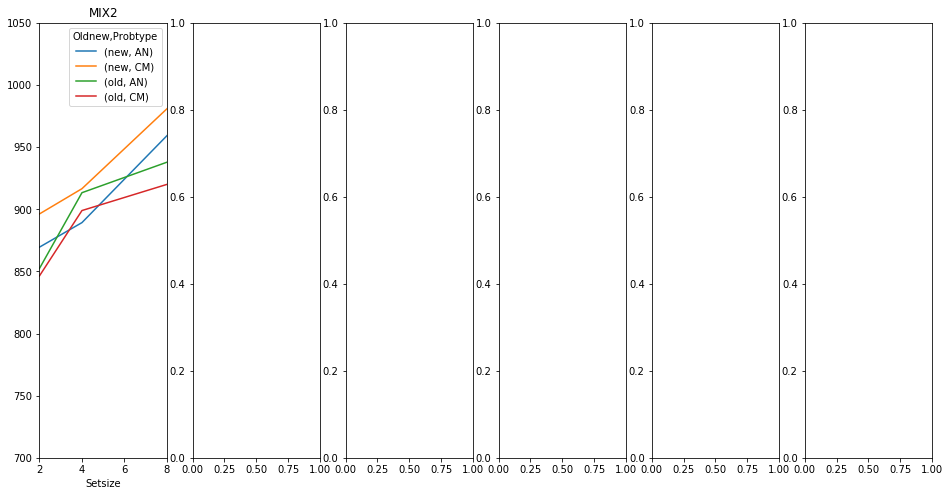

<Figure size 432x288 with 0 Axes>

true


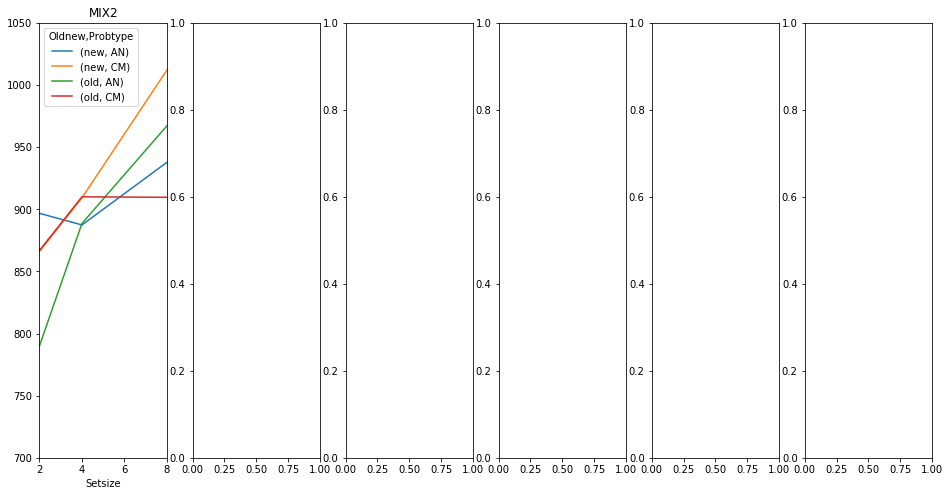

<Figure size 432x288 with 0 Axes>


From Grant Plot:

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 0 3.20199898480006 ** 
 Prediction



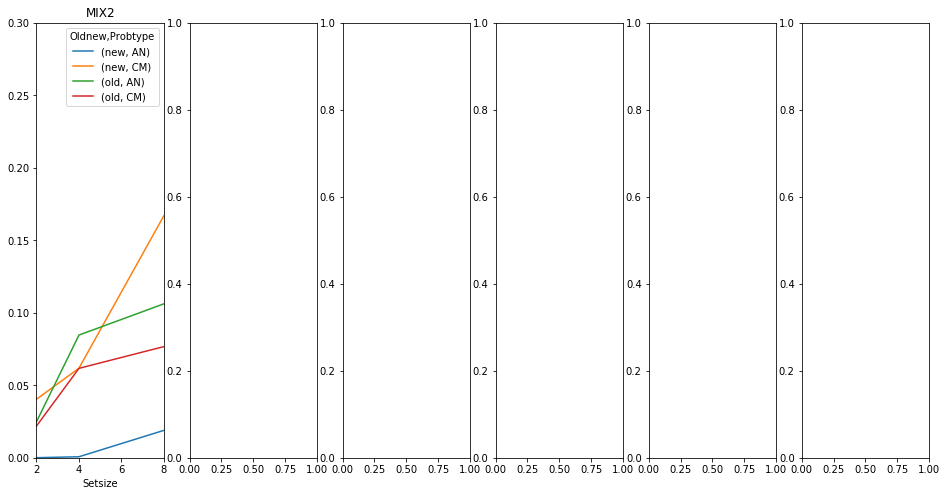

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 1 3.2225143495093596 ** 
 Prediction



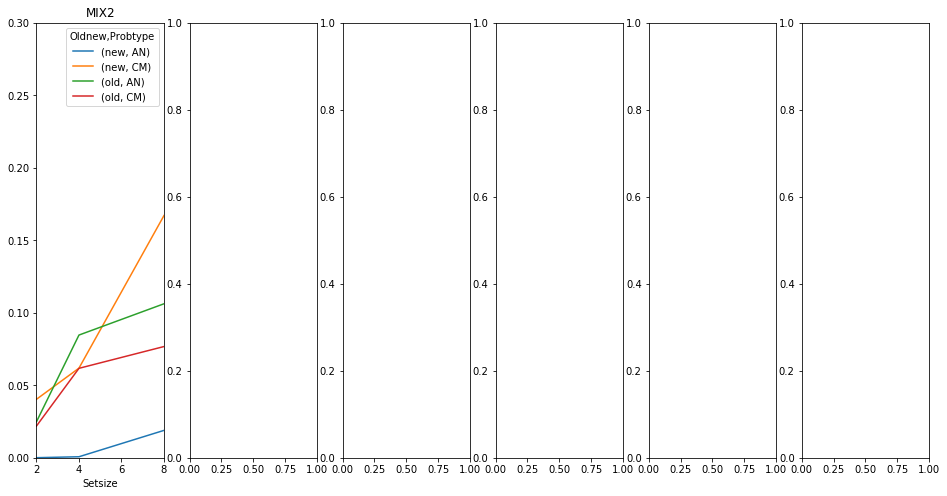

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 2 3.7592420380386002 ** 
 Prediction



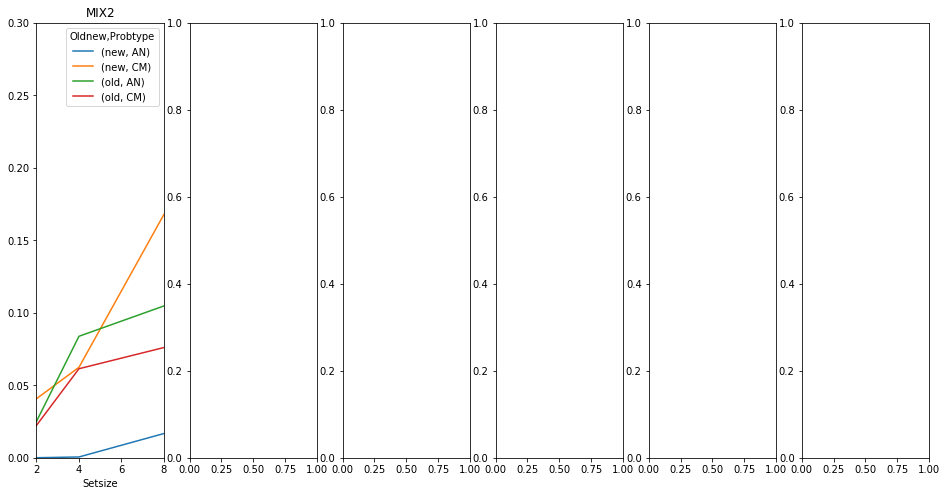

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 3 0.8363179232423911 ** 
 Prediction



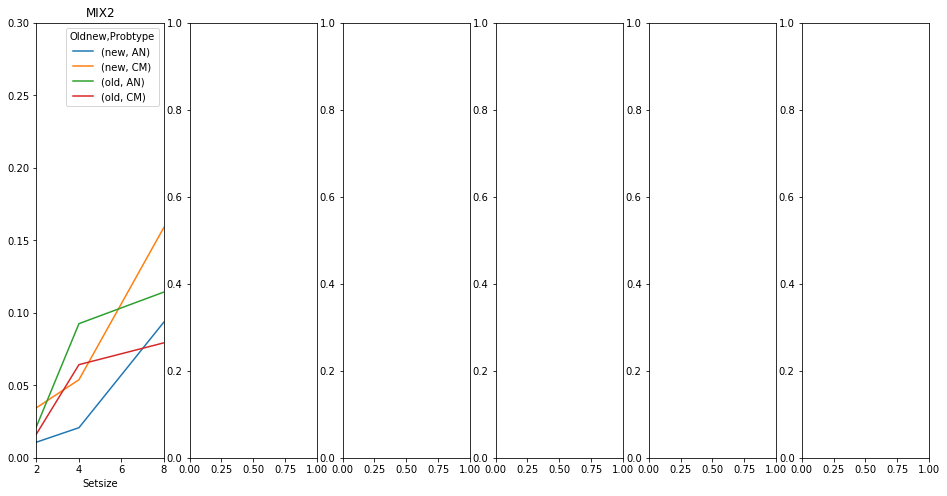

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 4 3.1497676083004302 ** 
 Prediction



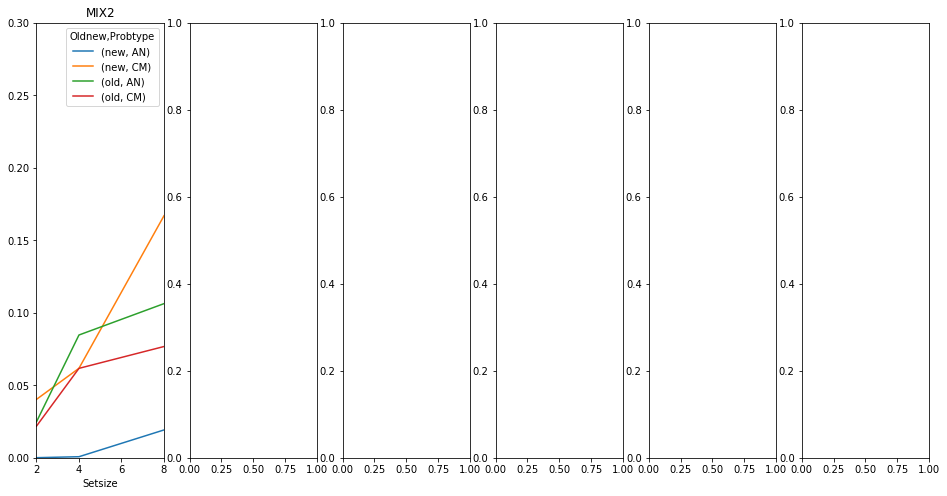

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 5 3.25696747983922 ** 
 Prediction



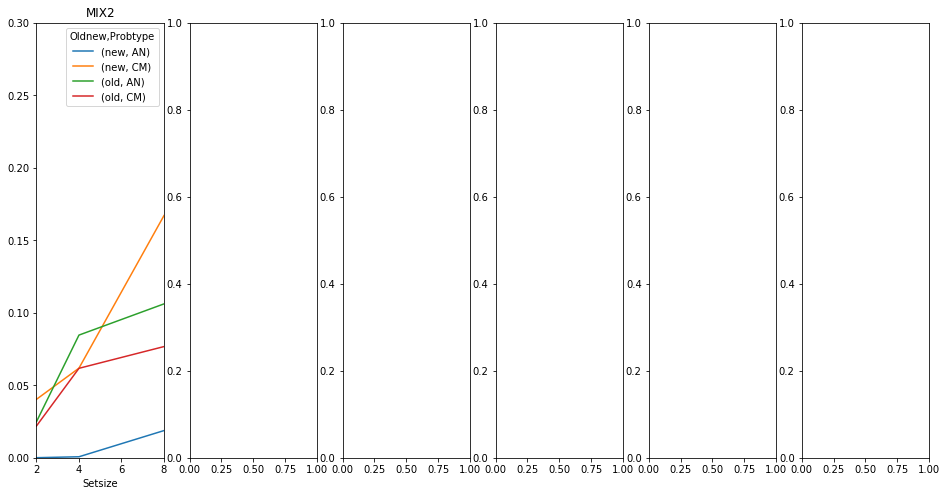

<Figure size 432x288 with 0 Axes>

search_MIX2==1 and vary_ss==1 and vary_ssan==0
** 6 0.840367886288404 ** 
 Prediction



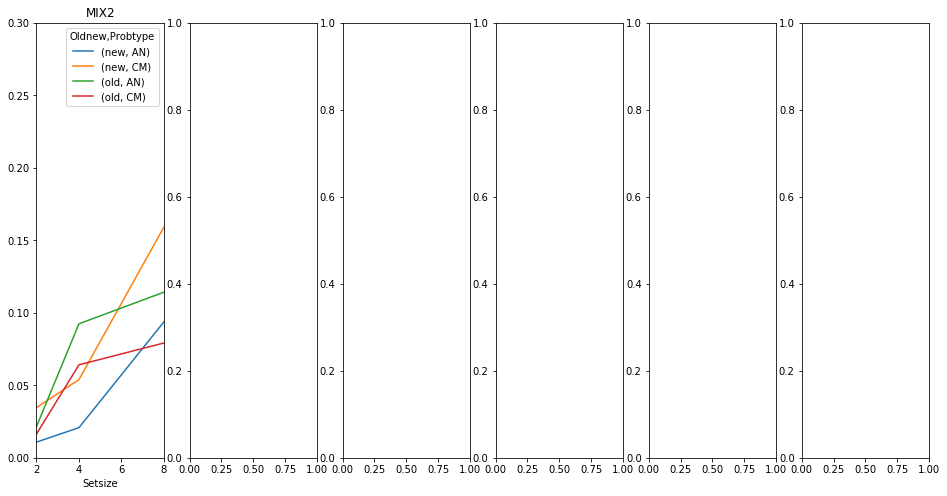

<Figure size 432x288 with 0 Axes>

true


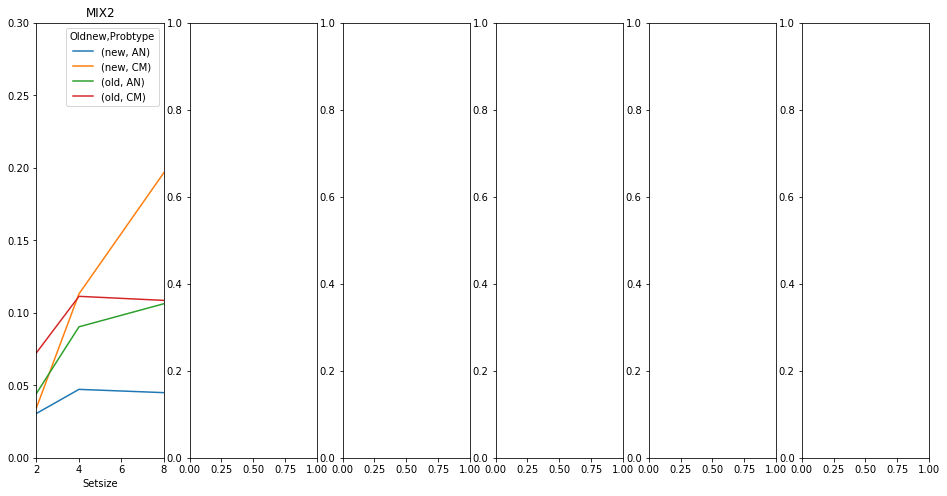

<Figure size 432x288 with 0 Axes>

In [16]:
global vary_ss, give_c2, vary_ssan, alphabeta_ANnew
vary_ss=1
vary_ssan=0
give_c2=0
alphabeta_ANnew=0

global nameset,is_search_allcondi_besideCMat,search_MIX1
is_search_allcondi_besideCMat=0
search_MIX1 = 0
search_MIX2 = 1

nm="12_02_12_33_puresingle_test_MIX2_vary_ss.csv"
# nm = "2019-12-04T05:16:46_single_test_MIX1_alphabeta-ANnew.csv"
# nm="2019-12-04T02:28:05_single_test_MIX2_ssANnew-FinalAdj.csv"
# nm="2019-12-04T05:37:00_single_test_MIX1_ssANnew-FinalAdj.csv"
# nm="2019-12-04T09:14:14_single_test_MIX2_alphabeta-ANnew.csv"
fitsel = pd.read_csv(nm).iloc[:,1:]

grant_plot(fitsel,"crt",700,1050)
grant_plot(fitsel,"err",0,0.3)

In [81]:
s

{'ss2': 0.01, 'ss4': 0.013194592807346, 'ss8': 0.021462827426077}